# Layered Model Starter Code

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Topography
- Land surface 100m above the datum on the left hand side
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Left boundary constant head 85m
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (2500, 2500)
     - Pumping at a rate of 500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.0001m/d
 - Extends from 25-35m above the base of the domain
 - The well is only completed in the lowest layer
     

## 1. Setup the environment

In [41]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [42]:
## model directory
moddir="C:/Users/justi/Documents/GW Modeling Repository/homework-justinheadley/mf2005"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers, I think this is only the variable in the one-layer scenario, but changing to 3 just in case

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: #using new csv file for HW12
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
# print(ztop.shape)
# print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 8.5    #assign horizontal hydraulic conductivity, will make more specific changes later in code
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
n = 0.10        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.10        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined


## Boundary conditions
#h_left = 85 #not actually specified in description (other than no-flow), so am just setting whole domain initially as h_right lower down 
h_right = 70

## 4. Setup and run MODFLOW for the three layer scenario 

In [43]:
#Initialize the model
modelname3 = "ThreeLayer"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

## Make some changes to the parameters                          *layer 0 is top* variable thickness, but constant bottom elevation
                                                                # bottom and middle layers have both constant thickness and elevation
                                                                
nlay2=3  #three layers instead of 1 (I removed the 1-layer scenario entirely from this code)
botm = np.zeros((nlay2,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m (meaning thickness of middle layer is 5m)

## Make a arrays for the K values, here is where I will be specific with K 
Kz = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = 0.0001               # K of the middle layer is the same as the lower layer in the leftmost 20 columns, 
                                     # but it is 0.0001 m/day in the z direction in the remaining columns, need to change columns 20-49. 

Kh = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array, Kh does not change for middle layer


#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay2, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay2, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = 0          #replace leftmost column (all zs, all ys, first x) with 0 to indicate no-flow boundary
ibound[:,0,:] = 0          #replace top row with 0 to indicate no-flow boundary (possibly unnecessary)
ibound[:,49,:] = 0          #replace bottom row with 0 to indicate no-flow boundary (possibly unnecessary)
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

# Creating no-flow conditions due to the bedrock
for i in range (0,6):             # received help with this, but I can at least explain it. Ex: in this line, for layer 0 (top),
    ibound[0:, i, 0:6-i] = 0      # when i=0 (row 0), columns 0-(6-i) (columns 0-6) will have it's ibound coded as 0 (no flow)
for i in range (0,8):             # then i goes to the next #, i=1, and now for row 1, columns 0-5 will be ibound=0, and so on until i=6
    ibound[1, i, 0:8-i] = 0       # then it goes onto the next line of code
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0  # these bottom 3 "for" statements are for the "bottom" (wrt y) bedrock
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0


#setup initial heads as the same as the right boundary (h=70)
H_init = np.ones((nlay2, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
recharge = 4e-4 #m/day, played with this number a bit to get model to converge
recharge_wheat = 1e-4 # rate of recharge if crop is wheat
recharge_pistachios = 1.5e-4 # rate of recharge if crop is pistachios
recharge_cotton = 2e-4 #rate of recharge if crop is cotton
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:14] = recharge # Recharge in the left-most 15 columns
#rech_zone[21:23,19:21] = recharge_wheat #change this depending on the crop
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)     #create rch object

#ET
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
Right_ET = 1e-3  # m/day. ET in the right half of the domain (columns 25-49 inclusive). played with this number a bit to get model to converge
Rip_ET = 5e-4 # m/day. ET in the riparian area, rows 22-28 inclusive (22-29 exclusive)
ET_zone[:,25:50] = Right_ET
ET_zone[22:29,:] = Rip_ET
extinction_depth = 1 # 1m everywhere , extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation
#evt is commented out because the model doesn't converge if it's not
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken

#Wells
#Q_town = -1500   # m^3/day given 
#Q_wheat = -3000   # m^3/day given  
#Q_pistachios = -4500   # m^3/day given
#Q_cotton = -6000   # m^3/day given

#fluxes1 = [2,21,38,Q_town] #bottom layer at row 21 and column 38
#fluxes2 = [0,12,14,Q_wheat] #top layer at row 12 and column 14, change Q_crop for different crops
#sp_fluxes = {0: [fluxes1, fluxes2]}   #create a dictionary with entries for each stress period



# Setup Stream Package

In [44]:
# Setup the stream characteristics 
stage = 0.5 # m, given
nseg = 3 # number of segments
ntrib=2 # two tributaries (for return flow & upstream section)
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0 # m^3/day
set_icalc = 1  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 

#2. Calculate the streambed conductance 
Kstream = 1.36 * K_horiz  # 1.36 * horizontal conductivity of top layer
sed_thicc = 1 #thickness of riverbed sediment 
cond = Kstream*(width)*(dy)/(sed_thicc) 

# Setup the reach locations stream segment numbers and reach numbers
# (Note we are taking a slightly more complicated approach here setting the streambed relative to the elevation of the land surface)
# Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#Setup the inflows for the reaches
return_loc = 25    #specifying the column where the town return flows come in
Qreturn = 50     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach

segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# Setup the elevation of the streams
#(In this case we will be setting it relative to surface elevation which is an array called ‘ztop’)

ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thicc      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

# Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], Kstream, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


# Setup the segments dictionary
# for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = np.zeros((10,nseg))
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')





# Run the Model

In [45]:
#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3, mxiter=500, iter1=500) #telling the model to iterate 500 times, to hopefully converge

#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/justi/Documents/GW Modeling Repository/homework-justinheadley/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ThreeLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:22:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:22:28
 Elapsed run time:  0.192 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

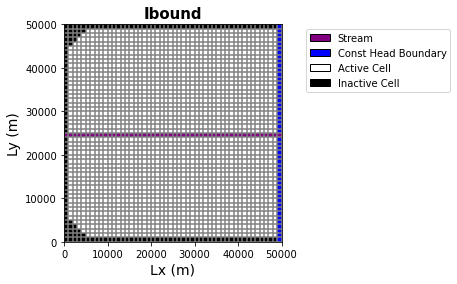

In [46]:
modelmap = flopy.plot.PlotMapView(model=m3, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

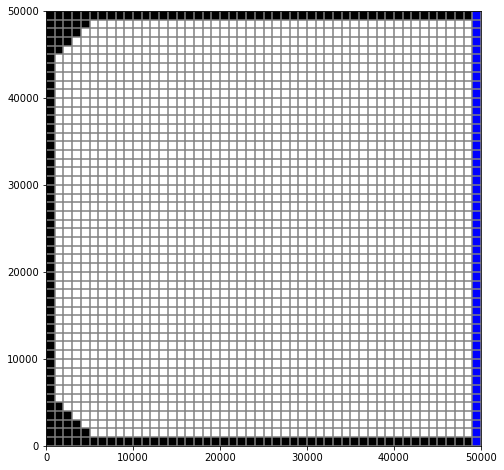

In [47]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m3)
ibound = mapview.plot_ibound()
#wel = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

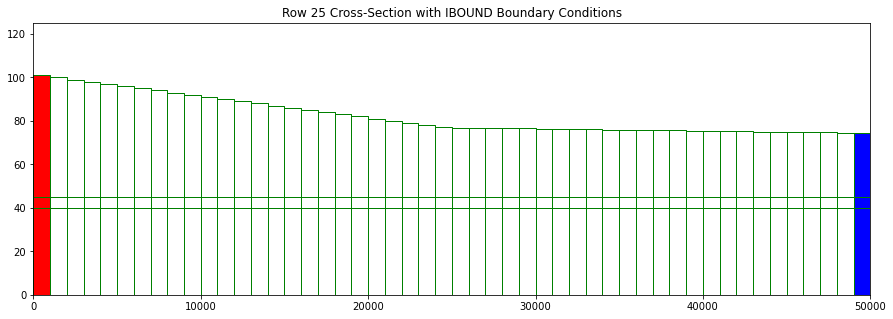

In [48]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [49]:
#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj3.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
1


# 8. Plotting
### 8.1 Cross section plots

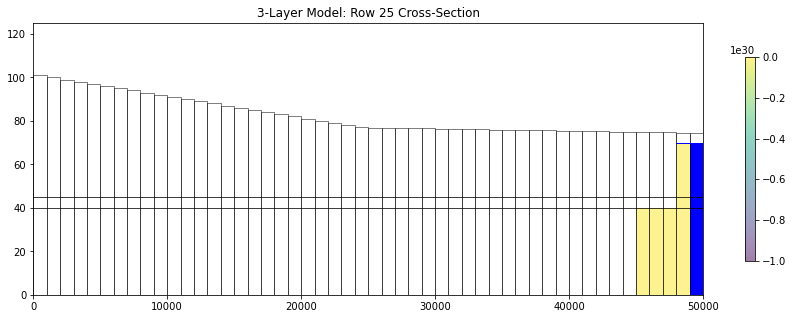

In [50]:

#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3-Layer Model: Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


# 9. Additional plots
### 9.1 Plot head transect

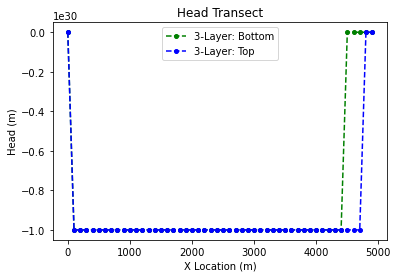

In [51]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head3[2,int(25),:],marker='o', color='green', markersize=4, linestyle='--', label="3-Layer: Bottom")
plt.plot(x,head3[0,int(25),:],marker='o', color='blue', markersize=4, linestyle='--', label="3-Layer: Top")
plt.title('Head Transect')
plt.xlabel('X Location (m)')
plt.ylabel('Head (m)')
plt.legend()

# plt.savefig('Head_Transect.png')

### 9.3 3 Layer head contours

C:\Users\justi\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\justi\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


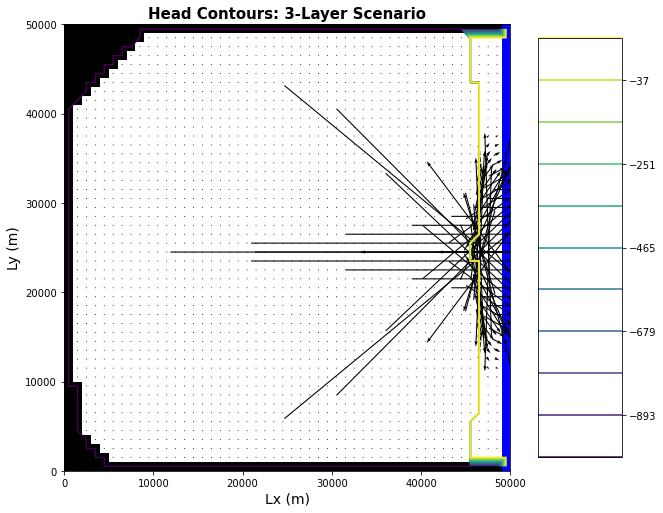

In [52]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Head Contours: 3-Layer Scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   